# fast.torch
This should be a template for training self-supervised models using PyTorch and fastai. 

In [24]:
import sys
sys.path.append('../')

from data import EMSelfPlay
from custom_transforms import RandomCutOut, GaussianBlur, ToGrayScale
from utils import show_sample, show_result, get_inpainting_transforms
from enum import Enum
from model import DynamicUnet
import numpy as np
import pandas as pd
from tqdm import tqdm

# import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image

from torchvision import models, transforms
import matplotlib.pyplot as plt
from pathlib import Path

In [25]:
# Computer SPECS
gpu_id = 1
num_cores = 4
torch.cuda.set_device(gpu_id)

## DATA

In [26]:
# hyper parameters
bs = 8  # batch size
size = 512  # image size
temperature = 0.5  # tau in SimCLR equation
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets/hr/')

In [27]:
img_pths = list(data_pth.glob('*.tif'))

In [28]:
train_set = pd.read_csv('../train.csv')
valid_set = pd.read_csv('../valid.csv')
len(train_set.values), len(valid_set.values)

(79997, 20000)

In [29]:
config = {'min_n_holes': 10, 'max_n_holes': 15, 
          'min_size': 5, 'max_size': 10}
size = 512
tfms = get_inpainting_transforms(size, config=config)
print(tfms)

{'x': Compose(
    ToGrayScale(3)
    CenterCrop(size=(512, 512))
    RandomCutOut(10, 15, 5, 5)
    ToTensor()
), 'y': Compose(
    ToGrayScale(1)
    CenterCrop(size=(512, 512))
    ToTensor()
)}


In [30]:
class SimCLRDataTransform(object):
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, sample):
        xi = self.transform(sample)
        xj = self.transform(sample)
        return xi, xj
    
    
    def __repr__(self):
        return f'{self.__class__.__name__}()'

In [31]:
def get_simclr_transforms(size, degrees=(-45, 45)):
    # get a set of data augmentation transformations as described in the SimCLR paper.
    tfms = transforms.Compose([ToGrayScale(3), 
                               transforms.CenterCrop(size=size),
                               transforms.RandomRotation(degrees=degrees),
                               transforms.RandomHorizontalFlip(),
                               RandomCutOut(20, 30, 10, 25),
                               GaussianBlur(kernel_size=int(0.1 * size)),
                               transforms.ToTensor()])
    return tfms

In [32]:
tfms = get_simclr_transforms(512)
tfms

Compose(
    ToGrayScale(3)
    CenterCrop(size=(512, 512))
    RandomRotation(degrees=(-45, 45), resample=False, expand=False)
    RandomHorizontalFlip(p=0.5)
    RandomCutOut(20, 30, 10, 10)
    ToTensor()
)

In [33]:
class EMSimCLR(Dataset):
    """A PyTorch Dataset class for self-supervised learning 
    on Electro-magnetic Microscopy Images.
    
    :param data_pth: Path object containing the absolute path to the target images
    :param transforms: Dictionary of transformations for the input and target images. 
    
    The transforms for the inputs defines the self-supervised pre-text task.
    See get_selfplay_transforms() in utils.py for an example definition.
    """

    def __init__(self, data_pth, transforms=None):
        self.img_filepaths = np.squeeze(data_pth).tolist()
        self.transforms = transforms
        
    def __len__(self):
        return len(self.img_filepaths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.img_filepaths[idx]
        y = Image.open(img_name)
        xi, xj = SimCLRDataTransform(self.transforms)(y)
        return xi, xj

In [34]:
train_set = pd.read_csv('../train.csv')
train_ds = EMSimCLR(train_set, transforms=tfms)

valid_set = pd.read_csv('../valid.csv')
valid_ds = EMSimCLR(valid_set, transforms=tfms)

In [35]:
train_dl = DataLoader(train_ds, batch_size=bs,
                      shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=bs,
                      shuffle=True, num_workers=4)

In [36]:
# %debug
xi, xj = train_ds[2]

In [37]:
xi.shape

torch.Size([3, 512, 512])

In [38]:
xj.shape

torch.Size([3, 512, 512])

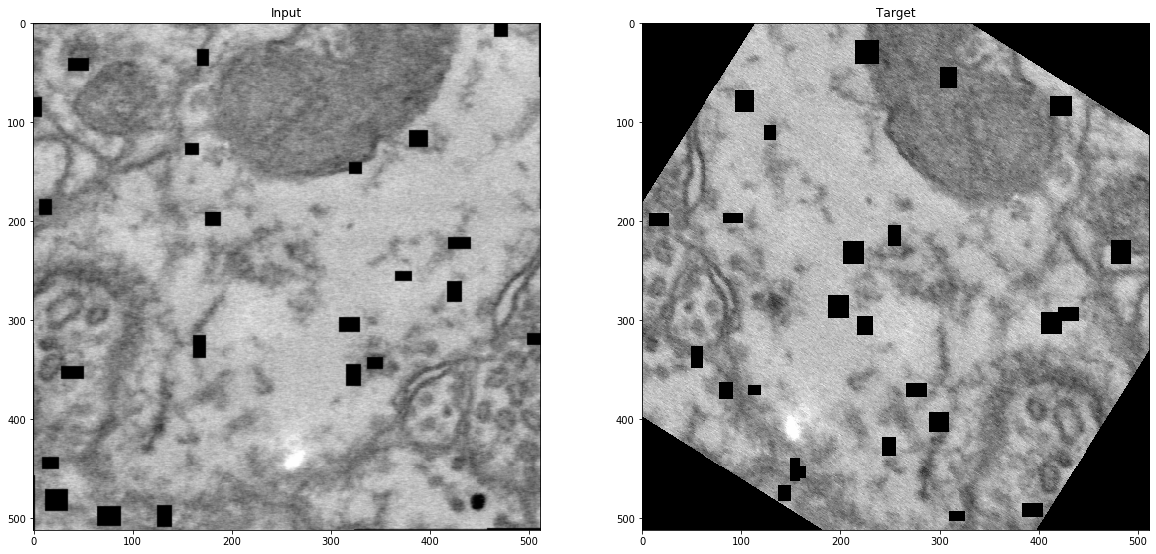

In [39]:
show_sample(train_ds)

## MODEL

In [40]:
arch = models.resnet34(False)

# encoder = nn.Sequential(*list(arch.children())[:-1])
arch.fc.in_features

512

In [41]:
class ResNetSimCLR(nn.Module):

    def __init__(self, out_dim, pretrained=False):
        super(ResNetSimCLR, self).__init__()
        resnet = models.resnet34(pretrained)
        num_ftrs = resnet.fc.in_features

        self.features = nn.Sequential(*list(resnet.children())[:-1])

        # projection MLP
        self.l1 = nn.Linear(num_ftrs, num_ftrs)
        self.l2 = nn.Linear(num_ftrs, out_dim)

    def _get_basemodel(self, model_name):
        try:
            model = self.resnet_dict[model_name]
            print("Feature extractor:", model_name)
            return model
        except:
            raise ("Invalid model name. Check the config file and pass one of: resnet18 or resnet50")

    def forward(self, x):
        h = self.features(x)
        h = h.squeeze()

        x = self.l1(h)
        x = F.relu(x)
        x = self.l2(x)
        return h, x

In [42]:
embdedding_size = 512
model = ResNetSimCLR(embdedding_size)
model;

## TRAINING

In [43]:
class NTXentLoss(nn.Module):
    """Loss function for Simple Contrastive Learning of Visual Representations"""
    def __init__(self, device, batch_size, temperature):
        super(NTXentLoss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.device = device
        self.softmax = torch.nn.Softmax(dim=-1)
        self.mask_samples_from_same_repr = self._get_correlated_mask().type(torch.bool)
        self.criterion = torch.nn.CrossEntropyLoss(reduction="sum")


    def _get_correlated_mask(self):
        diag = np.eye(2 * self.batch_size)
        l1 = np.eye((2 * self.batch_size), 2 * self.batch_size, k=-self.batch_size)
        l2 = np.eye((2 * self.batch_size), 2 * self.batch_size, k=self.batch_size)
        mask = torch.from_numpy((diag + l1 + l2))
        mask = (1 - mask).type(torch.bool)
        return mask.to(self.device)
    
    def similarity_function(self, acts1, acts2):
        return self._cosine_similarity(acts1, acts2)
    

    @staticmethod
    def _dot_similarity(x, y):
        v = torch.tensordot(x.unsqueeze(1), y.T.unsqueeze(0), dims=2)
        # x shape: (N, 1, C)
        # y shape: (1, C, 2N)
        # v shape: (N, 2N)
        return v

    def _cosine_similarity(self, x, y):
        # x shape: (N, 1, C)
        # y shape: (1, 2N, C)
        # v shape: (N, 2N)
        v = F.cosine_similarity(x, y.unsqueeze(dim=1), dim=-1)
        return v

    def forward(self, zis, zjs):
        representations = torch.cat([zjs, zis], dim=0)

        similarity_matrix = self.similarity_function(representations, representations)

        # filter out the scores from the positive samples
        l_pos = torch.diag(similarity_matrix, self.batch_size)
        r_pos = torch.diag(similarity_matrix, -self.batch_size)
        positives = torch.cat([l_pos, r_pos]).view(2 * self.batch_size, 1)

        negatives = similarity_matrix[self.mask_samples_from_same_repr].view(2 * self.batch_size, -1)

        logits = torch.cat((positives, negatives), dim=1)
        logits /= self.temperature

        labels = torch.zeros(2 * self.batch_size).to(self.device).long()
        loss = self.criterion(logits, labels)

        return loss / (2 * self.batch_size)

In [44]:
loss_function = NTXentLoss('cuda', bs, temperature)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [47]:
def validate(model, dataloader):
    running_loss = 0.0
    with tqdm(total=len(dataloader)) as pbar:
        for i, sample in enumerate(dataloader):
            xis, xjs = sample
            xis = xis.cuda()
            xjs = xjs.cuda()
            ris, zis = model(xis)  # [N,C]

            # get the representations and the projections
            rjs, zjs = model(xjs)  # [N,C]

            # normalize projection feature vectors
            zis = F.normalize(zis, dim=1)
            zjs = F.normalize(zjs, dim=1)


            valid_loss = loss_function(zis, zjs)
            running_loss += valid_loss.item()
            pbar.update(1)
            break
    return running_loss / (i+1)

In [48]:
# %debug
num_epochs = 1
total_loss = 0.0
print_every = 10
running_loss = 0.0
model.cuda()
for i in range(num_epochs):
    model.train()
    for j, sample_batch in enumerate(train_dl):
        # get the inputs; data is a list of [inputs, labels]
        xis, xjs = sample_batch
        xis = xis.cuda()
        xjs = xjs.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        
        # get the representations and the projections
        ris, zis = model(xis)  # [N,C]

        # get the representations and the projections
        rjs, zjs = model(xjs)  # [N,C]

        # normalize projection feature vectors
        zis = F.normalize(zis, dim=1)
        zjs = F.normalize(zjs, dim=1)

 
        loss = loss_function(zis, zjs)
        loss.backward()
        optimizer.step()

        # print statistics
        total_loss += loss.item()
        running_loss += loss.item()
        if j % (print_every) == 0:
            print(f'Epoch {i+1} Batch {j+1} loss: {running_loss/print_every}')
            running_loss = 0.0
            break
    model.eval()
    train_loss = total_loss / (j+1)
    print("Validating Model...")
    valid_loss = validate(model, valid_dl)
    print(f'Epoch {i+1} Train loss: {train_loss:.4f}, Valid loss: {valid_loss:.4f}')

Epoch 1 Batch 1 loss: 0.26267414093017577


  0%|          | 0/2500 [00:00<?, ?it/s]

Validating Model...


  0%|          | 1/2500 [00:03<2:37:24,  3.78s/it]

Epoch 1 Train loss: 2.626741409301758, Valid loss: 2.630770444869995


# DEV

In [ ]:
xis, xjs = next(iter(clr_dataloader))
xis.shape, xjs.shape

In [ ]:
model.cuda();
xis = xis.cuda()
xjs = xjs.cuda()

In [ ]:
optimizer.zero_grad()
ris, zis = model(xis)
rjs, zjs = model(xjs)
zis.shape, zjs.shape

In [61]:
zis = F.normalize(zis, dim=1)
zjs = F.normalize(zjs, dim=1)
zis.shape, zjs.shape

(torch.Size([4, 512]), torch.Size([4, 512]))

In [48]:
representations = torch.cat([zjs, zis], dim=0)
representations.shape

torch.Size([8, 512])

In [51]:
S = F.cosine_similarity(representations, representations.unsqueeze(dim=1), dim=-1)
S.shape

torch.Size([8, 8])

In [54]:
l_pos = torch.diag(S, 4)
l_pos.shape

torch.Size([4])

In [55]:
r_pos = torch.diag(S, -4)
r_pos.shape

torch.Size([4])

In [62]:
# %debug
loss_function(zis, zjs)

tensor(1.9341, device='cuda:1', grad_fn=<DivBackward0>)

In [64]:
torch.diag()

torch.Size([4, 512])